In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
import os
 
train_data = pd.read_table('~/aiffel/senti/ratings_train.txt')
test_data = pd.read_table('~/aiffel/senti/ratings_test.txt')

train_data.head()


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터로더 구성

In [2]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any')
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

In [3]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [4]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 모델 구성을 위한 데이터 분석 및 가공

In [5]:
# 라벨확인

print(x_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [6]:
# 데이터셋 내 문장 길이 분포 확인

total_data_text = list(x_train) + list(x_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


In [7]:
# 적절한 최대 문장길이 지정

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [8]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## 모델 구성 및 validation set 구성

In [9]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9

In [10]:
# 검증셋 분리

# validation set 10000건 분리
x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


## 모델 훈련 개시

In [11]:
# 학습

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 6s 6ms/step - loss: 0.4831 - accuracy: 0.7655 - val_loss: 0.3522 - val_accuracy: 0.8472
Epoch 2/10
266/266 [==============================] - 1s 5ms/step - loss: 0.3282 - accuracy: 0.8601 - val_loss: 0.3385 - val_accuracy: 0.8528
Epoch 3/10
266/266 [==============================] - 1s 6ms/step - loss: 0.2975 - accuracy: 0.8761 - val_loss: 0.3345 - val_accuracy: 0.8555
Epoch 4/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2735 - accuracy: 0.8890 - val_loss: 0.3376 - val_accuracy: 0.8540
Epoch 5/10
266/266 [==============================] - 1s 4ms/step - loss: 0.2483 - accuracy: 0.9018 - val_loss: 0.3466 - val_accuracy: 0.8509
Epoch 6/10
266/266 [==============================] - 1s 5ms/step - loss: 0.2212 - accuracy: 0.9147 - val_loss: 0.3647 - val_accuracy: 0.8498
Epoch 7/10
266/266 [==============================] - 2s 6ms/step - loss: 0.1935 - accuracy: 0.9277 - val_loss: 0.3884 - val_accuracy: 0.8448
Epoch 

In [12]:
# 평가

results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5036 - accuracy: 0.8321
[0.5035508275032043, 0.832129716873169]


## Loss, Accuracy 그래프 시각화

In [13]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


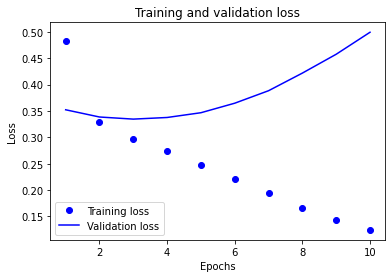

In [14]:
# 학습에따른 loss 확인

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

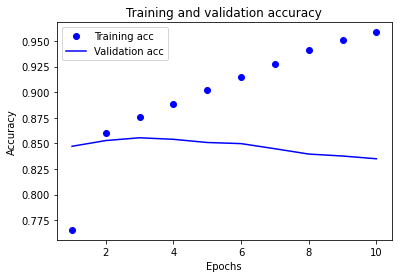

In [15]:
# accuracy 확인

plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 학습된 Embedding 레이어 분석

In [16]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 16)


In [17]:
# 학습한 Embedding 파라미터를 파일에 써서 저장 
word2vec_file_path = os.getenv('HOME')+'/aiffel/senti/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 벡터사이즈

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [24]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['공포']
vector

array([ 0.0260437 ,  0.00894753,  0.01229104, -0.00955382, -0.06974939,
        0.06332591,  0.03929665, -0.00683178, -0.05116075, -0.12180469,
        0.02501881, -0.01082864,  0.04260695,  0.02465277,  0.03091166,
        0.02242989], dtype=float32)

In [25]:
# 단어 유사도 확인

word_vectors.similar_by_word("공포")

[('줄리아', 0.7759808301925659),
 ('수백', 0.7718720436096191),
 ('총체', 0.7433919906616211),
 ('종합', 0.727118194103241),
 ('등장인물', 0.7212510704994202),
 ('이범수', 0.7169958353042603),
 ('의도', 0.7085838317871094),
 ('복제', 0.7065367102622986),
 ('뱀파이어', 0.7048137187957764),
 ('발하', 0.6921102404594421)]

In [30]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=1000000)
vector = word2vec['angry']
vector     # 무려 300dim의 워드 벡터

array([ 0.22265625,  0.08789062,  0.12597656, -0.10546875, -0.30078125,
        0.0546875 ,  0.05102539, -0.11474609,  0.15234375,  0.32421875,
       -0.11230469, -0.17089844, -0.02233887,  0.06445312, -0.10742188,
       -0.01574707, -0.10302734,  0.17089844,  0.07910156, -0.0534668 ,
        0.15429688,  0.24414062,  0.38476562,  0.07958984,  0.0378418 ,
        0.02893066,  0.00909424, -0.07373047,  0.41796875, -0.23535156,
        0.26367188,  0.06933594, -0.18652344,  0.02001953,  0.26953125,
       -0.20019531,  0.18652344,  0.04443359, -0.16308594,  0.22753906,
        0.1328125 , -0.10839844,  0.22851562, -0.27148438, -0.31445312,
       -0.21582031, -0.34960938, -0.06933594, -0.35546875, -0.01916504,
       -0.15234375,  0.05126953, -0.14550781,  0.04980469,  0.05371094,
        0.22460938, -0.08349609, -0.22558594, -0.01416016, -0.12695312,
       -0.01953125,  0.07714844, -0.265625  ,  0.11621094, -0.21582031,
       -0.03515625,  0.02172852, -0.08398438, -0.15136719, -0.11

In [31]:
word2vec.similar_by_word("angry")

[('irate', 0.8138925433158875),
 ('enraged', 0.7705066800117493),
 ('indignant', 0.7013434171676636),
 ('incensed', 0.6881307363510132),
 ('annoyed', 0.6847162246704102),
 ('agitated', 0.6821000576019287),
 ('frustrated', 0.6720573306083679),
 ('furious', 0.6702253222465515),
 ('unhappy', 0.6646261811256409),
 ('outraged', 0.6598437428474426)]

## 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [32]:
vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [33]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [34]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/15
266/266 [==============================] - 4s 10ms/step - loss: 0.5953 - accuracy: 0.6557 - val_loss: 0.4629 - val_accuracy: 0.7767
Epoch 2/15
266/266 [==============================] - 2s 9ms/step - loss: 0.3775 - accuracy: 0.8348 - val_loss: 0.3686 - val_accuracy: 0.8368
Epoch 3/15
266/266 [==============================] - 2s 9ms/step - loss: 0.3304 - accuracy: 0.8600 - val_loss: 0.3586 - val_accuracy: 0.8426
Epoch 4/15
266/266 [==============================] - 2s 9ms/step - loss: 0.3040 - accuracy: 0.8726 - val_loss: 0.3478 - val_accuracy: 0.8494
Epoch 5/15
266/266 [==============================] - 2s 8ms/step - loss: 0.2851 - accuracy: 0.8830 - val_loss: 0.3529 - val_accuracy: 0.8478
Epoch 6/15
266/266 [==============================] - 2s 9ms/step - loss: 0.2657 - accuracy: 0.8926 - val_loss: 0.3554 - val_accuracy: 0.8505
Epoch 7/15
266/266 [==============================] - 2s 9ms/step - loss: 0.2491 - accuracy: 0.9009 - val_loss: 0.3597 - val_accuracy: 0.8501
Epoch

In [35]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5782 - accuracy: 0.8210
[0.5782423615455627, 0.8210427761077881]
